# **Project 3: Collaborative Filtering**



*Lumi Huang, Christian Warloe, Ke Zhao, Landi Luo*

---



## Introduction  

Recommender systems play a major role in today's e-commerce industry. Many e-commerce and retail companies are leveraging the power of data and boosting sales by implementing recommender systems on their websites. The basic idea behind recommender systems is that they aim to predict users’ interests and recommend items that quite likely are interesting for them, based on the users' previous data (explicit user ratings after watching a movie or listening to a song, implicit search engine queries and purchase histories, or from other knowledge about the users/items themselves). Sites like Spotify, YouTube or Netflix use that data in order to suggest playlists or to make video/movie recommendations.  

In this project, we will build a recommendation system using collaborative filtering methods. Collaborative filtering models use *user-item interactions* data, such as ratings or number of purchases. We will implement and analyze the performance of two types of collaborative filtering methods:   

1.   Neighborhood-based collaborative filtering
2.   Model-based collaborative filtering

## MovieLens dataset

In this project, we used the `MovieLens` dataset to build a recommendation system to predict the ratings of the movies in the dataset. The dataset can be downloaded using the following link: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip  

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from [MovieLens](https://movielens.org/), a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html

In [0]:
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#upload the dataset into the google drive
data = pd.read_csv('gdrive/My Drive/ratings.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data.shape

(100836, 4)

In [0]:
#get column names
data.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [0]:
#build R matrix
r_matrix = data.pivot(index = 'userId', columns = 'movieId', values = 'rating')

In [0]:
print(r_matrix.shape)

(610, 9724)


**Question 1: Compute the sparsity of the movie rating dataset, where sparsity is defined by equation below:**  

$sparsity=\frac{\text{Total number of available ratings}}{\text{Total number of possible ratings}}=0.01699968$  

In [0]:
sparsity = r_matrix.count().sum()/(r_matrix.shape[0] * r_matrix.shape[1])
print(sparsity)

0.016999683055613623


**Question 2: Plot a histogram showing the frequency of the rating values. To be specific, bin the rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R with rating values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram**

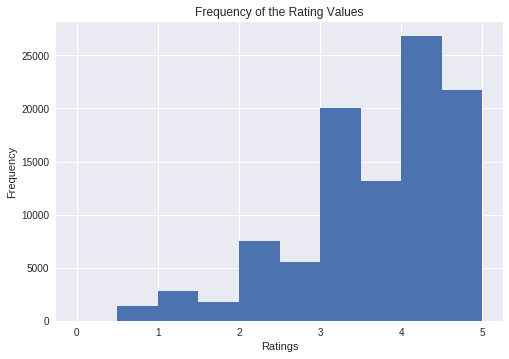

In [0]:
import matplotlib.pyplot as plt

ratings = data['rating']

plt.hist(ratings, bins= np.arange(5.5, step=0.5), align='mid')
plt.title('Frequency of the Rating Values')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

From the histagram above, we can see that most ratings lie between 3 and 5. It shows that users in our dataset tend to give higher ratings. This information might be helpful when converting the observed ratings (continuous scale) to a binary scale. For example, in question 15, we were asked to threshold the observed ratings. If the observed rating is greater than the threshold value, then we set it to 1 (like). If the observed rating is less than the threshold value, then we set it to 0 (dislike). Because our ratings are mostly located between 3 and 5, adjusting the threshold to higher values may help on transforming the observed continuous data into like and dislike (binary scale).

**Question 3: Plot the distribution of the number of ratings received among movies. To be specific, the X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received. For example, the movie that has the largest number of ratings has index 1; ties can broken in any way. A monotonically decreasing curve instead of a histogram is expected.**    

The plot below shows the number of ratings received among movies, ordered in decreasing frequency. We observe that the higest number of ratings for a movie is between 250-300 ratings. But most of the ~10,000 movies in the dataset have less than 100 ratings. 




In [0]:
rating_dist = r_matrix.count().sort_values(ascending=False).reset_index()
rating_dist.columns = ['movieId', 'freq']

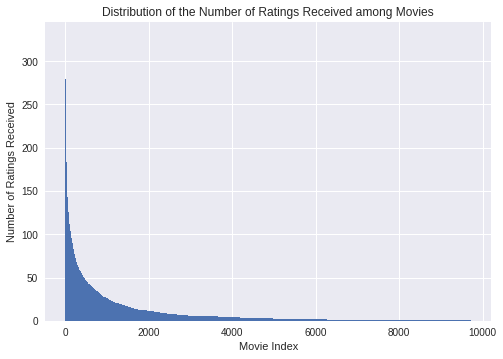

In [0]:
plt.bar(rating_dist.index + 1, rating_dist['freq'], align='center', width=1)
plt.title('Distribution of the Number of Ratings Received among Movies')
plt.xlabel('Movie Index')
plt.ylabel('Number of Ratings Received')
plt.show()

In [0]:
rating_dist[5000:5005]

,movieId,freq
5000,2071,2
5001,5238,2
5002,5224,2
5003,67186,2
5004,27899,2


**Question 4: Plot the distribution of ratings among users. To be specific, the X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user have rated. The requirement of the plot is similar to that in Question 3.**  

In addition to looking at the distribution of ratings among movies, we also plotted the distribution of ratings among users (Figure 3). The x-axis displays the user index ordered by decreasing frequency, and the y-axis is the number of movies the user have rated. The plot follows a similar distribution as Figure 2, also a monotonically decreasing curve. User ID 414 gave the most ratings among all the users, with a frequency of 2698 ratings given. However, among the 610 users, most of them have given less than 100 ratings. 

In [0]:
rating_dist_user = r_matrix.notna().sum(axis=1).sort_values(ascending=False).reset_index()
rating_dist_user.columns = ['userId', 'freq']

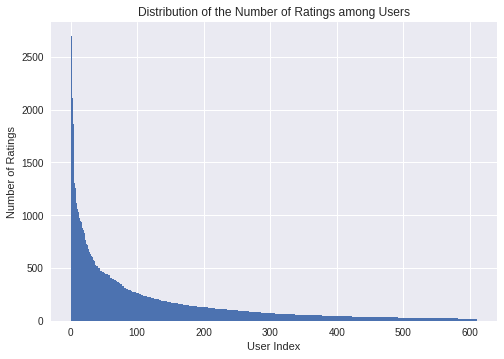

In [0]:
plt.bar(rating_dist_user.index + 1, rating_dist_user['freq'], align='center', width=1)
plt.title('Distribution of the Number of Ratings among Users')
plt.xlabel('User Index')
plt.ylabel('Number of Ratings')
plt.show()

**Question 5: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.**

A salient feature of Figure 2 from Question 3 is the shape of the distribution, which looks similar to an exponentially decreasing function. Since only a few movies received a substantial amount of ratings, this implies that the ratings matrix R will be sparse. This corresponds with our sparsity measure in Question 1, which indicated a low number of available ratings compared to the number of possible ratings. In addition, we also observed that many of the movies received very few ratings, with around half of the movies having received only 2 or less ratings. This makes prediction of the movie ratings difficult since we have very little prior data to build the predictions on. 

**Question 6: Compute the variance of the rating values received by each movie. Then, bin the variance values into intervals of width 0.5 and use the binned vari- ance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the histogram**

In [0]:
var_movie = np.var(r_matrix, axis=0)

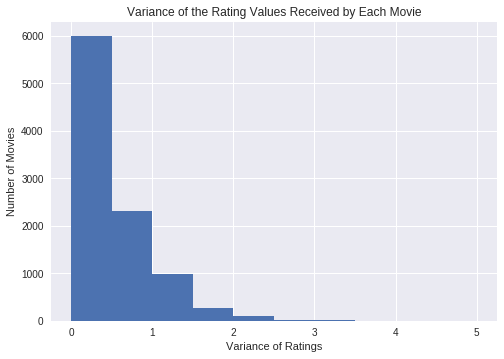

In [0]:
plt.hist(var_movie, bins=np.arange(5.5, step=0.5), align='mid')
plt.title('Variance of the Rating Values Received by Each Movie')
plt.xlabel('Variance of Ratings')
plt.ylabel('Number of Movies')
plt.show()

## Neighborhood-based collaborative filtering

### 1. User-based neighborhood models

### 2. Pearson-correlation coefficient

**Question 7: Write down the formula for μu in terms of Iu and ruk**

$ \mu_u$ = Mean rating for user u computed using her specified ratings  
$ I_u $ = Set of item indices for which ratings have been specified by user u  
$ r_{uk}$ = Rating of user u for item k  

$\ \mu_u =  \frac{1}{I_u} \sum\limits_{k \in I_u}r_{uk} $ 

**Question 8: In plain words, explain the meaning of $\ I_u \cap I_v$. Can $\ I_u \cap I_v = \emptyset $
(Hint: Rating matrix R is sparse).**

 $\ I_u \cap I_v$ is the intersect of sets of item indices for which ratings have been specified by user u and user v. That is, a set of movies that have been rated by both user u and user v. $\ I_u \cap I_v = \emptyset $ can be true. This is because R is sparse, and it is possible that user u and user v have specified ratings for completely different movies. If none of the movies are rated by both user u and user v, then $\ I_u \cap I_v$ is a null set.

### 3. K-Nearest neighborhood (k-NN)

### 4. Prediction function

**Question 9: Can you explain the reason behind mean-centering the raw ratings $\ (r_{vj} − \mu_v)$ in the prediction function?**  
Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function

This is because different users have different rating standard. Some users may have higher standard, and they would probably give lower ratings. By mean-centering the raw ratings $\ (r_{vj} − \mu_v)$ in the prediction function, we can account for the systematic higher/lower ratings by each user

$\hat{r}_{uj}$

### 5. K-NN collaborative filter

#### Design and test via cross-validation

In [0]:
#install surprise
!pip install scikit-surprise

    100% |████████████████████████████████| 3.3MB 6.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import accuracy


In [0]:
#import data for surprise package
file_path = 'gdrive/My Drive/ratings.csv'
reader = Reader(line_format='user item rating', sep=',', skip_lines=1, rating_scale=(0, 5))
data_s = Dataset.load_from_file(file_path, reader=reader)

**Question 10: Design a k-NN collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).**

In [0]:
nfold = 10
sim_options = {'name':'pearson'}
knn = np.arange(2, 101, step=2)
rmse = []
mae = []

for k in knn:
  algo = KNNWithMeans(k=k, sim_options=sim_options)
  cv = cross_validate(algo, data_s, measures=['RMSE', 'MAE'], cv=nfold, verbose=False)
  rmse.append(np.mean(cv['test_rmse']))
  mae.append(np.mean(cv['test_mae']))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

In [0]:
acc_cv = pd.concat([pd.DataFrame(knn), pd.DataFrame(rmse), pd.DataFrame(mae)], axis=1)
acc_cv.columns = ['k', 'RMSE', 'MAE']

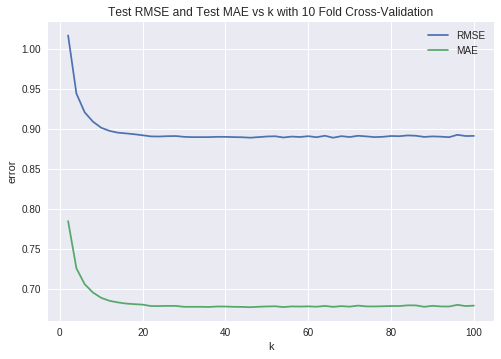

In [0]:
import matplotlib.pyplot as plt

plt.plot(acc_cv['k'], acc_cv['RMSE'])
plt.plot(acc_cv['k'], acc_cv['MAE'])
plt.xlabel('k')
plt.ylabel('error')
plt.title('Test RMSE and Test MAE vs k with 10 Fold Cross-Validation')
plt.legend(['RMSE','MAE'], loc='upper right')
plt.show()

**Question 11: Use the plot from question 10, to find a ’minimum k’.**  
Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converges to a steady-state value. Please report the steady state values of average RMSE and average MAE




In [0]:
opt_k1 = knn[rmse.index(min(rmse))]
print(opt_k1)
opt_k2 = knn[mae.index(min(mae))]
print(opt_k2)

66
46


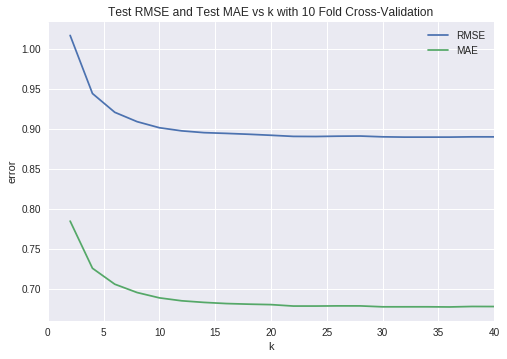

In [0]:
#take a closer look at the grah 

plt.plot(acc_cv['k'], acc_cv['RMSE'])
plt.plot(acc_cv['k'], acc_cv['MAE'])
plt.xlim(0, 40)
plt.xlabel('k')
plt.ylabel('error')
plt.title('Test RMSE and Test MAE vs k with 10 Fold Cross-Validation')
plt.legend(['RMSE','MAE'], loc='upper right')
plt.show()

The steady state values of RMSE and MAE are about k=25

### 6. Filter performance on trimmed test set

**Question 12: Design a k-NN collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**

In [0]:
from surprise.model_selection import KFold

In [0]:
#movie Id of popular movies
popular_movieId = list(rating_dist['movieId'][rating_dist['freq'] > 2])

In [0]:
# kf = KFold(n_splits=10)

# knn = np.arange(2, 101, step=2)
# rmse = []
# sim_options = {'name':'pearson'}

# for k in knn:
#   algo = KNNWithMeans(k=k, sim_options=sim_options)
#   for trainset, testset in kf.split(data_s):
#     # train and test algorithm.
#     rmse_10=[]
#     algo.fit(trainset)    
#     predictions = algo.test(testset)
#     rmse_10.append(accuracy.rmse(predictions, verbose=True))
#     # Compute and print Root Mean Squared Error
#   rmse.append(np.mean(rmse_10))

In [0]:
def popular_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in popular_movieId:
      trim_test.append(testset[i])
  return trim_test

In [0]:
kf = KFold(n_splits=10)

knn = np.arange(2, 101, step=2)
rmse = []
sim_options = {'name':'pearson'}

for k in knn:
  algo = KNNWithMeans(k=k, sim_options=sim_options)
  for trainset, testset in kf.split(data_s):
    # train and test algorithm.
    rmse_10=[]
    algo.fit(trainset)
    trim_test = popular_trim(testset)
    
    predictions = algo.test(trim_test)
    rmse_10.append(accuracy.rmse(predictions, verbose=True))
    
  rmse.append(np.mean(rmse_10))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0210
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0135
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0001
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0118
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0170
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0218
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0176
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0064
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0032
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0082
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9454
Computing 

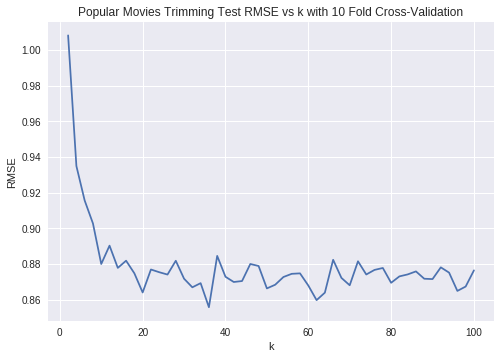

Minimum RMSE: 0.8557


In [0]:
import matplotlib.pyplot as plt

plt.plot(knn, rmse)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Popular Movies Trimming Test RMSE vs k with 10 Fold Cross-Validation')
plt.show()

print('Minimum RMSE: %.4f' % min(rmse))


**Question 13: Design a k-NN collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**


In [0]:
unpopular_movieId = list(rating_dist['movieId'][rating_dist['freq'] <= 2])

In [0]:
def unpopular_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in unpopular_movieId:
      trim_test.append(testset[i])
  return trim_test

In [0]:
kf = KFold(n_splits=10)

knn = np.arange(2, 101, step=2)
rmse_up = []
sim_options = {'name':'pearson'}

for k in knn:
  algo = KNNWithMeans(k=k, sim_options=sim_options)
  for trainset, testset in kf.split(data_s):
    # train and test algorithm.
    rmse_10=[]
    algo.fit(trainset)
    trim_test = unpopular_trim(testset)
    
    predictions = algo.test(trim_test)
    rmse_10.append(accuracy.rmse(predictions, verbose=True))
    
  rmse_up.append(np.mean(rmse_10))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1126
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0842
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1106
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1134
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1312
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1457
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1283
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0949
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1632
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1230
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1160
Computing 

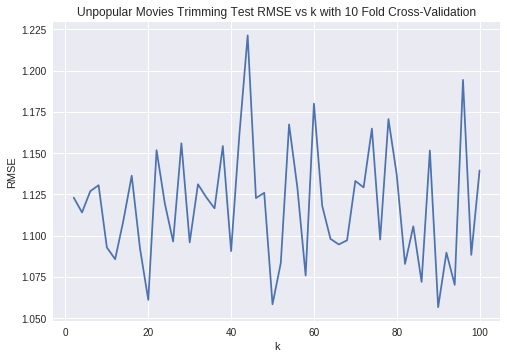

Minimum RMSE: 1.0567


In [0]:
import matplotlib.pyplot as plt

plt.plot(knn, rmse_up)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Unpopular Movies Trimming Test RMSE vs k with 10 Fold Cross-Validation')
plt.show()

print('Minimum RMSE: %.4f' % min(rmse_up))

**Question 14: Design a k-NN collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**

In [0]:
high_var = pd.concat([pd.DataFrame(np.var(r_matrix, axis=0)), pd.DataFrame(r_matrix.count())], axis=1).reset_index()
high_var.columns = ['movieId', 'var', 'freq']

In [0]:
highvar_movieId = list(high_var['movieId'][(high_var['var'] >= 2) & (high_var['freq'] >= 5)])

In [0]:
def highvar_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in highvar_movieId:
      trim_test.append(testset[i])
  return trim_test

In [0]:
kf = KFold(n_splits=10)

knn = np.arange(2, 101, step=2)
rmse_hv = []
sim_options = {'name':'pearson'}

for k in knn:
  algo = KNNWithMeans(k=k, sim_options=sim_options)
  for trainset, testset in kf.split(data_s):
    # train and test algorithm.
    rmse_10=[]
    algo.fit(trainset)
    trim_test = highvar_trim(testset)
    
    predictions = algo.test(trim_test)
    rmse_10.append(accuracy.rmse(predictions, verbose=True))
    
  rmse_hv.append(np.mean(rmse_10))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5000
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.7590
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5802
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3324
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6145
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3899
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2.0337
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6627
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.3938
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6747
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.4151
Computing 

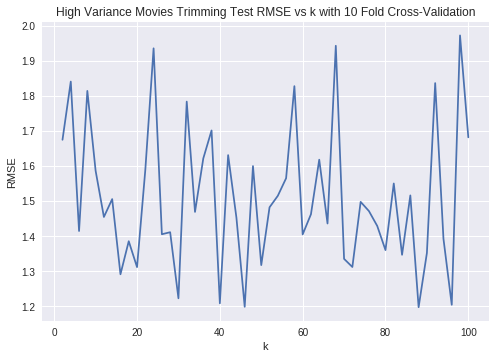

Minimum RMSE: 1.1978


In [0]:
import matplotlib.pyplot as plt

plt.plot(knn, rmse_hv)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('High Variance Movies Trimming Test RMSE vs k with 10 Fold Cross-Validation')
plt.show()

print('Minimum RMSE: %.4f' % min(rmse_hv))

#### Performance evaluation using ROC curve



**Question 15: Plot the ROC curves for the k-NN collaborative filter designed in question 10 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the k found in question 11. For each of the plots, also report the area under the curve (AUC) value.**


In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNWithMeans
import matplotlib.pyplot as plt


Computing the pearson similarity matrix...
Done computing similarity matrix.


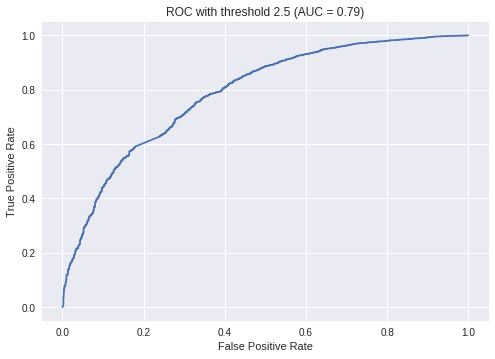

Computing the pearson similarity matrix...
Done computing similarity matrix.


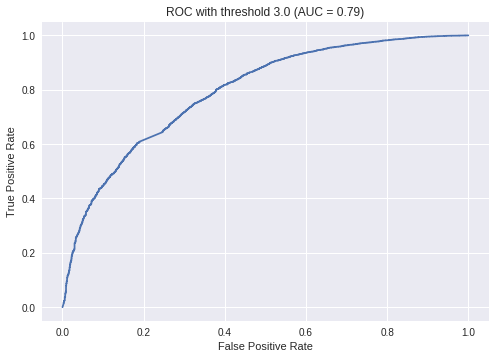

Computing the pearson similarity matrix...
Done computing similarity matrix.


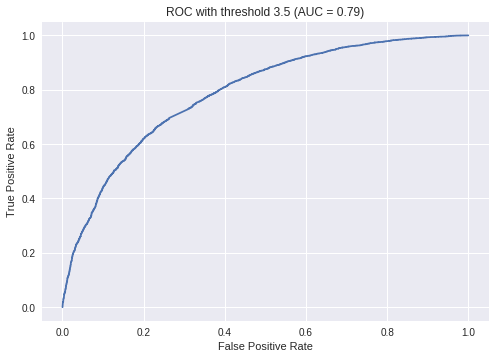

Computing the pearson similarity matrix...
Done computing similarity matrix.


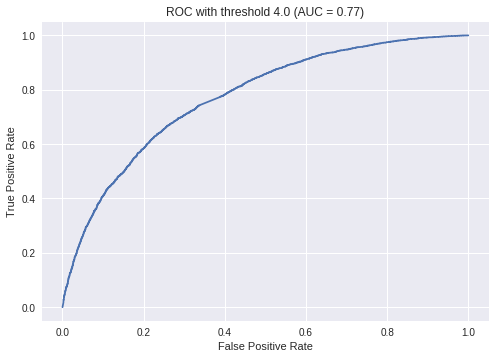

In [0]:
#from question 10
opt_k=25
threshold = [2.5, 3, 3.5, 4]
sim_options = {'name':'pearson'}

for t in threshold:
  trainset, testset = train_test_split(data_s, test_size=.1)
  algo = KNNWithMeans(k=opt_k, sim_options=sim_options)
  algo.fit(trainset)
  predictions = algo.test(testset)
  y_true = []
  y_est = []
  for row in predictions:
    y_true.append(row.r_ui)
    y_est.append(row.est)
  
  #convert rating to binary scale
  binary_true=[]
  for i in range(len(y_true)):
    binary_true.append(1 if y_true[i] >= t else 0)  
    
  
  #plot roc curve
  fpr, tpr, threshold = roc_curve(binary_true, y_est)
  roc_auc = roc_auc_score(binary_true, y_est)
  plt.plot(fpr, tpr)
  plt.title('ROC with threshold %0.1f (AUC = %0.2f)' % (t, roc_auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
  
  
  


## Model-based collaborative

### 1. Latent factor based collaborative filtering

### 2. non-negative matrix factorization (NNMF)

**Question 16: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.**

A function$\ f$ is said to be convex at an interval if, for all pairs of
points on the$\ f(x)$ graph, the line segment that connects these two points passes above the$\ f(x) $ curve. This optimization problem given by equation 5 is not convex because the Hessian for the equation  

$\ minimize_{U, V} \sum\limits_{i=1}^{m} W_{ij}(r_{ij} - (UV^T)_{ij})^2 $
is not positive defined.

Given U is fixed, we can treat U as a parameter of the varaible V, and $\ U{V}^T $ here can be seen as an estimate of the ground truth $\ r_{ij}$. Therefore, we can formulate it as a least square problem.

**1. Prediction function**



Given U, V from equation 5, we can now use U, V to predict the ratings. The predicted rating of user for item j, denoted as $\ \hat{r}_{ij}$, is given by  

$\ \hat{r}_{ij} = \sum\limits_{s=1}^{k}u_{is} v_{js} $

**2. Design and test via cross-validation**

**Question 17: Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.**

In [0]:
from surprise.prediction_algorithms.matrix_factorization import NMF

In [0]:
nfold = 10
k = np.arange(2, 52, 2)

rmse = []
mae = []

for k in k:
  algo = NMF(n_factors=k)
  cv = cross_validate(algo, data_s, measures=['RMSE', 'MAE'], cv=nfold, verbose=False)
  rmse.append(np.mean(cv['test_rmse']))
  mae.append(np.mean(cv['test_mae']))

In [0]:
accuracy = pd.concat([pd.DataFrame(np.arange(2, 52, 2)), pd.DataFrame(rmse), pd.DataFrame(mae)], axis=1)
accuracy.columns = ['k', 'RMSE', 'MAE']

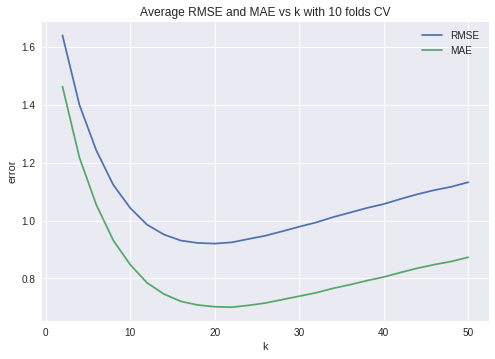

In [0]:
import matplotlib.pyplot as plt

plt.plot(accuracy['k'], accuracy['RMSE'])
plt.plot(accuracy['k'], accuracy['MAE'])
plt.title('Average RMSE and MAE vs k with 10 folds CV')
plt.xlabel('k')
plt.ylabel('error')
plt.legend(['RMSE', 'MAE'], loc='upper right')
plt.show()

**Question 18: Use the plot from question 17, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?**

In [0]:
print('the minimum average RMSE is', min(accuracy['RMSE']))
print('the minimum average MAE is', min(accuracy['MAE']))

the minimum average RMSE is 0.9203250882912071
the minimum average MAE is 0.7004655573935168


In [0]:
index_rmse = rmse.index(min(rmse))
accuracy.iloc[index_rmse]

k       20.000000
RMSE     0.920325
MAE      0.702190
Name: 9, dtype: float64

In [0]:
index_mae = mae.index(min(mae))
accuracy.iloc[index_mae]

k       22.000000
RMSE     0.924433
MAE      0.700466
Name: 10, dtype: float64

**3. NNMF filter performance on trimmed test set**

**Question 19: Design a NNMF collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**

In [0]:
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.matrix_factorization import NMF

In [0]:
popular_movieId = list(rating_dist['movieId'][rating_dist['freq'] > 2])

In [0]:
def popular_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in popular_movieId:
      trim_test.append(testset[i])
  return trim_test

In [0]:
kf = KFold(n_splits=10)

k = np.arange(2, 52, step=2)
rmse = []

for k in k:
  algo = NMF(n_factors=k)
  rmse_10=[]
  for trainset, testset in kf.split(data_s):
    # train and test algorithm.
    algo.fit(trainset)
    trim_test = popular_trim(testset)
    
    predictions = algo.test(trim_test)
    rmse_10.append(accuracy.rmse(predictions, verbose=False))
    
  rmse.append(np.mean(rmse_10))

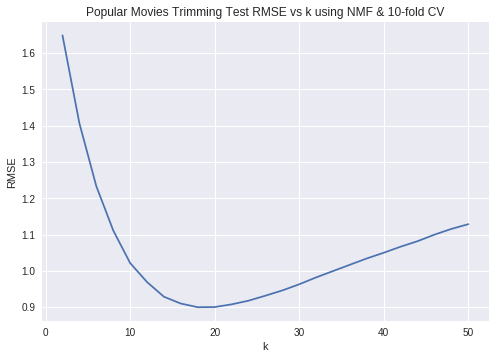

Minimum RMSE: 0.8997


In [0]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2, 52, step=2), rmse)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Popular Movies Trimming Test RMSE vs k using NMF & 10-fold CV')
plt.show()

print('Minimum RMSE: %.4f' % min(rmse))

**Question 20: Design a NNMF collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**

In [0]:
unpopular_movieId = list(rating_dist['movieId'][rating_dist['freq'] <= 2])

In [0]:
def unpopular_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in unpopular_movieId:
      trim_test.append(testset[i])
  return trim_test

In [0]:
kf = KFold(n_splits=10)

k = np.arange(2, 52, step=2)
rmse_up = []

for k in k:
  algo = NMF(n_factors=k)
  rmse_10=[]
  for trainset, testset in kf.split(data_s):
    # train and test algorithm.
    algo.fit(trainset)
    trim_test = unpopular_trim(testset)
    
    predictions = algo.test(trim_test)
    rmse_10.append(accuracy.rmse(predictions, verbose=False))
    
  rmse_up.append(np.mean(rmse_10))

In [0]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2, 52, step=2), rmse_up)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Unpopular Movies Trimming Test RMSE vs k using NMF & 10-fold CV')
plt.show()

print('Minimum RMSE: %.4f' % min(rmse_up))

**Question 21: Design a NNMF collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s perfor- mance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**

In [0]:
high_var = pd.concat([pd.DataFrame(np.var(r_matrix, axis=0)), pd.DataFrame(r_matrix.count())], axis=1).reset_index()
high_var.columns = ['movieId', 'var', 'freq']

In [0]:
highvar_movieId = list(high_var['movieId'][(high_var['var'] >= 2) & (high_var['freq'] >= 5)])

In [0]:
def highvar_trim(testset):
  trim_test = []
  for i in range(len(testset)):
    if int(testset[i][1]) in highvar_movieId:
      trim_test.append(testset[i])
  return trim_test

In [0]:
kf = KFold(n_splits=10)

k = np.arange(2, 51, step=2)
rmse_hv = []

for k in k:
  algo = NMF(n_factors=k)
  rmse_10=[]
  for trainset, testset in kf.split(data_s):
    # train and test algorithms
    algo.fit(trainset)
    trim_test = highvar_trim(testset)
    
    predictions = algo.test(trim_test)
    rmse_10.append(accuracy.rmse(predictions, verbose=False))
    
  rmse_hv.append(np.mean(rmse_10))

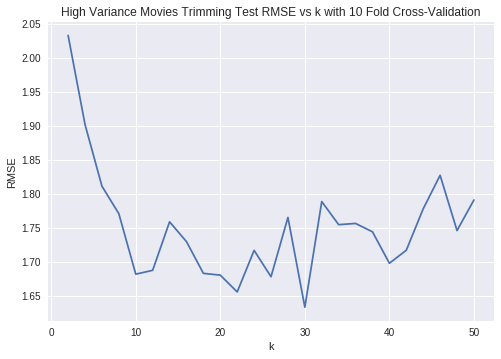

Minimum RMSE: 1.6333


In [0]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2, 52, step=2), rmse_hv)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('High Variance Movies Trimming Test RMSE vs k with 10 Fold Cross-Validation')
plt.show()

print('Minimum RMSE: %.4f' % min(rmse_hv))

**4. Performance evaluation using ROC curve**

**Question 22: Plot the ROC curves for the NNMF-based collaborative filter designed in question 17 for threshold values [2.5,3,3.5,4]. For the ROC plotting use the optimal number of latent factors found in question 18. For each of the plots, also report the area under the curve (AUC) value.**

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.model_selection import train_test_split

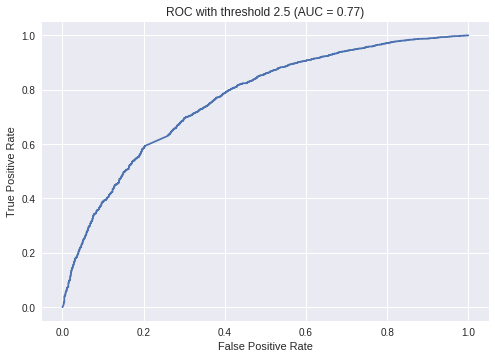

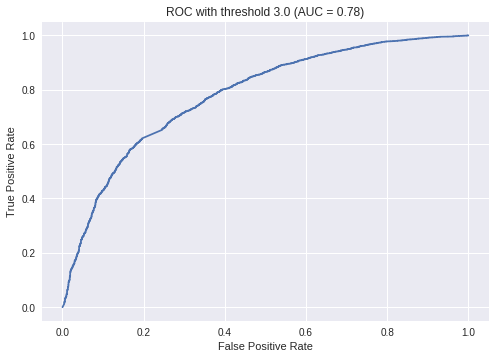

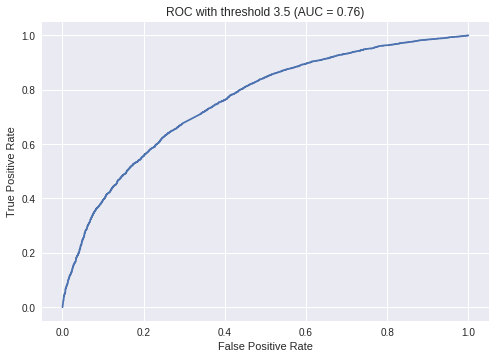

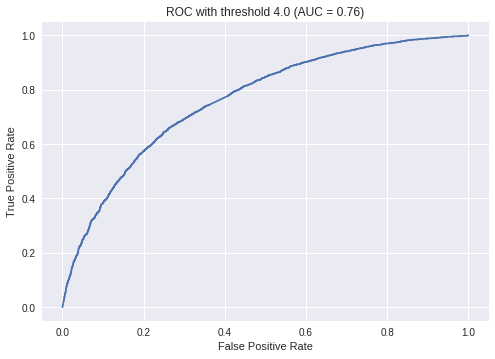

In [0]:
threshold = [2.5, 3, 3.5, 4]
opt_k=20

for t in threshold:
  trainset, testset = train_test_split(data_s, test_size=.1)
  algo = NMF(n_factors=opt_k)
  algo.fit(trainset)
  predictions = algo.test(testset)
  y_true = []
  y_est = []
  for row in predictions:
    y_true.append(row.r_ui)
    y_est.append(row.est)
  
  #convert rating to binary scale
  binary_true=[]
  for i in range(len(y_true)):
    binary_true.append(1 if y_true[i] >= t else 0)  
    
  
  #plot roc curve
  fpr, tpr, threshold = roc_curve(binary_true, y_est)
  roc_auc = roc_auc_score(binary_true, y_est)
  plt.plot(fpr, tpr)
  plt.title('ROC with threshold %0.1f (AUC = %0.2f)' % (t, roc_auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

**5. Interpretability of NNMF**

**Question 23: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?**


In [0]:
nmf_decomp = NMF(n_factors=20)
nmf_decomp.fit(data_s.build_full_trainset())

In [0]:
movies = pd.read_csv('gdrive/My Drive/movies.csv')
movies_mat = movies.set_index('movieId').T.to_dict()
for i in range(20):
  print('Genres in Row ' + str(i) + ':')
  top = np.argsort(nmf_decomp.qi[:,i])[-10:]
  for t in top:
    print(movies_mat[r_matrix.columns[t]]['title'] + ': ' + movies_mat[r_matrix.columns[t]]['genres'])
  print('\n')

  

Genres in Row 0:
Venom (1982): Horror|Thriller
Hunted, The (2003): Action|Drama|Thriller
Them (Ils) (2006): Horror
Home (2009): Documentary
Alice Doesn't Live Here Anymore (1974): Drama|Romance
Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000): Action|Drama|Romance
Spring, Summer, Fall, Winter... and Spring (Bom yeoreum gaeul gyeoul geurigo bom) (2003): Drama
Stir Crazy (1980): Comedy
Circus (2000): Crime|Drama|Thriller
Curious George (2006): Adventure|Animation|Children|Comedy


Genres in Row 1:
Protector, The (a.k.a. Warrior King) (Tom yum goong) (2005): Action|Comedy|Crime|Thriller
Master of the Flying Guillotine (Du bi quan wang da po xue di zi) (1975): Action
Night of the Iguana, The (1964): Drama|Thriller
Robin Hood (2010): Action|Adventure|Drama|Romance|War
Meet the Feebles (1989): Animation|Comedy|Musical
5 Centimeters per Second (Byôsoku 5 senchimêtoru) (2007): Animation|Drama|Romance
Harvey Girls, The (1946): Comedy|Musical|Western
U-571 (2000): Action|Thriller|War
Nigh

### 3. Matrix factorization with bias (MF with bias)

**1. Prediction function**

**2. Design and test via cross-validation**

**Question 24: Design a MF with bias collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter**

In [0]:
from surprise.prediction_algorithms.matrix_factorization import SVD

In [0]:
nfold = 10
ks = np.arange(2, 52, 2)

rmse = []
mae = []

for k in ks:
  algo = SVD(n_factors=k)
  cv = cross_validate(algo, data_s, measures=['RMSE', 'MAE'], cv=nfold, verbose=False)
  rmse.append(np.mean(cv['test_rmse']))
  mae.append(np.mean(cv['test_mae']))

In [0]:
accuracy = pd.concat([pd.DataFrame(np.arange(2, 52, 2)), pd.DataFrame(rmse), pd.DataFrame(mae)], axis=1)
accuracy.columns = ['k', 'RMSE', 'MAE']

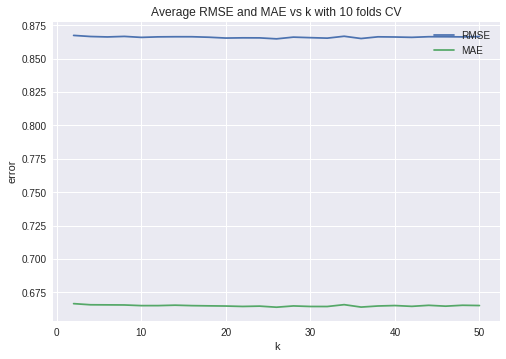

In [0]:
import matplotlib.pyplot as plt

plt.plot(accuracy['k'], accuracy['RMSE'])
plt.plot(accuracy['k'], accuracy['MAE'])
plt.title('Average RMSE and MAE vs k with 10 folds CV')
plt.xlabel('k')
plt.ylabel('error')
plt.legend(['RMSE', 'MAE'], loc='upper right')
plt.show()

**Question 25: Use the plot from question 24, to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE.**

In [0]:
print('the minimum average RMSE is', min(accuracy['RMSE']))
print('the minimum average MAE is', min(accuracy['MAE']))

the minimum average RMSE is 0.8648159309103371
the minimum average MAE is 0.6639783228987499


In [0]:
index_rmse = rmse.index(min(rmse))
accuracy.iloc[index_rmse]

k       26.000000
RMSE     0.864816
MAE      0.663978
Name: 12, dtype: float64

In [0]:
index_mae = mae.index(min(mae))
accuracy.iloc[index_mae]

k       26.000000
RMSE     0.864816
MAE      0.663978
Name: 12, dtype: float64

**3. MF with bias filter performance on trimmed test set**

In [0]:
from surprise import accuracy
kf = KFold(n_splits=10)

k = np.arange(2, 52, step=2)
pop_rmse = []
unpop_rmse = []
var_rmse = []

for k in k:
  algo = SVD(n_factors=k)
  pop_rmse_10=[]
  unpop_rmse_10=[]
  var_rmse_10=[]
  for trainset, testset in kf.split(data_s):
    # train and test algorithm.
    algo.fit(trainset)
    
    pop_trim_test = popular_trim(testset)
    pop_predictions = algo.test(pop_trim_test)
    pop_rmse_10.append(accuracy.rmse(pop_predictions, verbose=False))
    
    unpop_trim_test = unpopular_trim(testset)
    unpop_predictions = algo.test(unpop_trim_test)
    unpop_rmse_10.append(accuracy.rmse(unpop_predictions, verbose=False))
    
    var_trim_test = highvar_trim(testset)
    var_predictions = algo.test(var_trim_test)
    var_rmse_10.append(accuracy.rmse(var_predictions, verbose=False))
    
  pop_rmse.append(np.mean(pop_rmse_10))
  unpop_rmse.append(np.mean(unpop_rmse_10))
  var_rmse.append(np.mean(var_rmse_10))

**Question 26: Design a MF with bias collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**

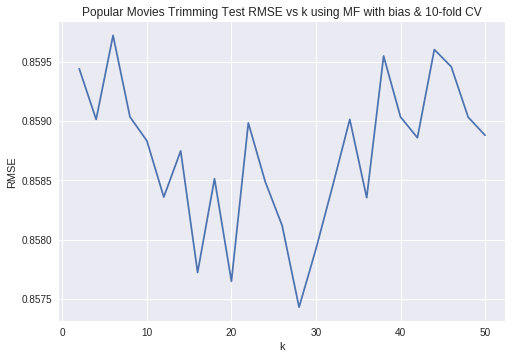

Minimum RMSE: 0.8574


In [0]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2, 52, step=2), pop_rmse)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Popular Movies Trimming Test RMSE vs k using MF with bias & 10-fold CV')
plt.show()

print('Minimum RMSE: %.4f' % min(pop_rmse))

**Question 27: Design a MF with bias collaborative filter to predict the rat- ings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob- tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**

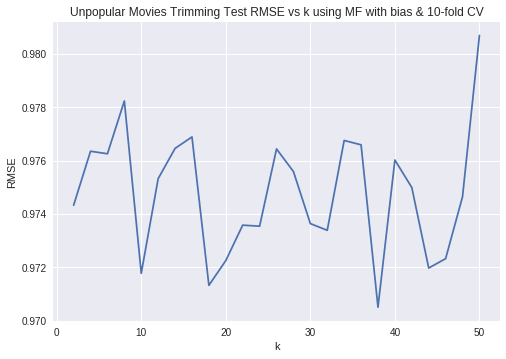

Minimum RMSE: 0.9705


In [0]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2, 52, step=2), unpop_rmse)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('Unpopular Movies Trimming Test RMSE vs k using MF with bias & 10-fold CV')
plt.show()

print('Minimum RMSE: %.4f' % min(unpop_rmse))

**Question 28: Design a MF with bias collaborative filter to predict the rat- ings of the movies in the high variance movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE ob- tained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE**

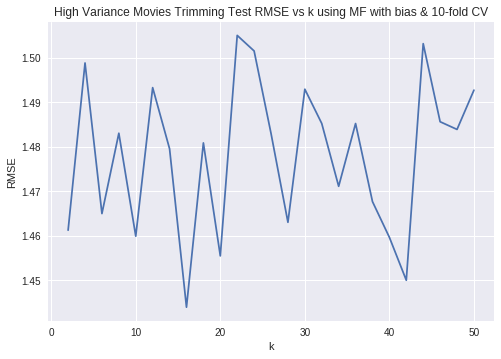

Minimum RMSE: 1.4439


In [0]:
import matplotlib.pyplot as plt

plt.plot(np.arange(2, 52, step=2), var_rmse)
plt.xlabel('k')
plt.ylabel('RMSE')
plt.title('High Variance Movies Trimming Test RMSE vs k using MF with bias & 10-fold CV')
plt.show()

print('Minimum RMSE: %.4f' % min(var_rmse))

**4. Performance evaluation using ROC curve**

**Question 29: Plot the ROC curves for the MF with bias collaborative filter designed in question 24 for threshold values [2.5,3,3.5,4]. For the ROC plot- ting use the optimal number of latent factors found in question 25. For each of the plots, also report the area under the curve (AUC) value.**

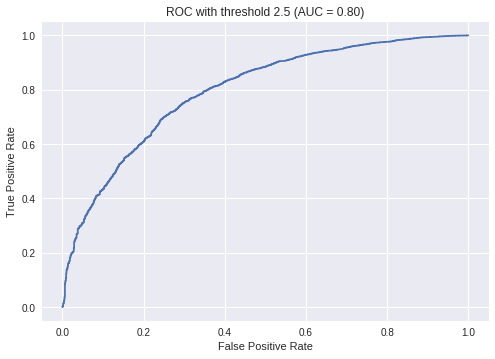

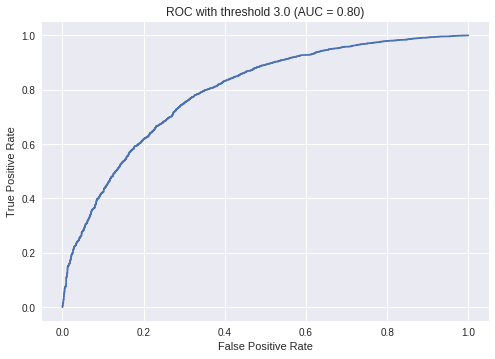

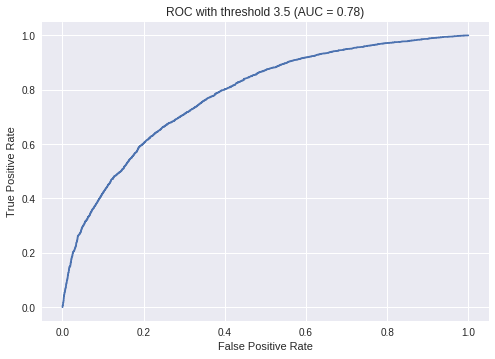

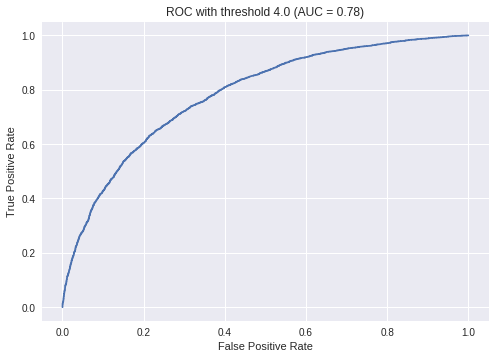

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise.model_selection import train_test_split

threshold = [2.5, 3, 3.5, 4]
opt_k=26

for t in threshold:
  trainset, testset = train_test_split(data_s, test_size=.1)
  algo = SVD(n_factors=opt_k)
  algo.fit(trainset)
  predictions = algo.test(testset)
  y_true = []
  y_est = []
  for row in predictions:
    y_true.append(row.r_ui)
    y_est.append(row.est)
  
  #convert rating to binary scale
  binary_true=[]
  for i in range(len(y_true)):
    binary_true.append(1 if y_true[i] >= t else 0)  
    
  
  #plot roc curve
  fpr, tpr, threshold = roc_curve(binary_true, y_est)
  roc_auc = roc_auc_score(binary_true, y_est)
  plt.plot(fpr, tpr)
  plt.title('ROC with threshold %0.1f (AUC = %0.2f)' % (t, roc_auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

## Naive collaborative filtering

### 1. Prediction function

### 2. Design and test via cross-validation

**Question 30: Design a naive collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.**  
Note that in this case, when performing the cross-validation, there is no need to calculate μi’s for the training folds each time. You are only asked to use a sin- gle set of μi’s calculated on the entire dataset and validate on 10 validation folds.

In [0]:
user_ratings = data_s.build_full_trainset().ur
user_avg_ratings = {}
for user in user_ratings:
  n = 0
  total = 0
  for rating in user_ratings[user]:
    n+=1
    total+=rating[1]
  user_avg_ratings[user] = total/n
rmses = []
for fold in range(10):
  trainset, testset = train_test_split(data_s, test_size=.1)
  mses = []
  for data in testset:
    user = data[0]
    true_rating = data[2]
    pred_rating = user_avg_ratings[int(user)-1]
    mses.append((true_rating-pred_rating)**2)
  rmses.append(np.sqrt(np.mean(mses)))
  
print(np.mean(rmses))
 

0.9357012529750481


### 3. Naive collaborative filter performance on trimmed test set

**Question 31: Design a naive collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.**

In [0]:
for fold in range(10):
  trainset, testset = train_test_split(data_s, test_size=.1)
  mses = []
  for data in popular_trim(testset):
    user = data[0]
    true_rating = data[2]
    pred_rating = user_avg_ratings[int(user)-1]
    mses.append((true_rating-pred_rating)**2)
  rmses.append(np.sqrt(np.mean(mses)))
  
print(np.mean(rmses))

0.9316774436854212


**Question 32: Design a naive collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.**

In [0]:
for fold in range(10):
  trainset, testset = train_test_split(data_s, test_size=.1)
  mses = []
  for data in unpopular_trim(testset):
    user = data[0]
    true_rating = data[2]
    pred_rating = user_avg_ratings[int(user)-1]
    mses.append((true_rating-pred_rating)**2)
  rmses.append(np.sqrt(np.mean(mses)))
  
print(np.mean(rmses))

0.9423359052203419


**Question 33: Design a naive collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it’s perfor- mance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.**

In [0]:
for fold in range(10):
  trainset, testset = train_test_split(data_s, test_size=.1)
  mses = []
  for data in highvar_trim(testset):
    user = data[0]
    true_rating = data[2]
    pred_rating = user_avg_ratings[int(user)-1]
    mses.append((true_rating-pred_rating)**2)
  rmses.append(np.sqrt(np.mean(mses)))
  
print(np.mean(rmses))

1.0754196462687842


## Performance comparison

**Question 34: Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.**

Computing the pearson similarity matrix...
Done computing similarity matrix.


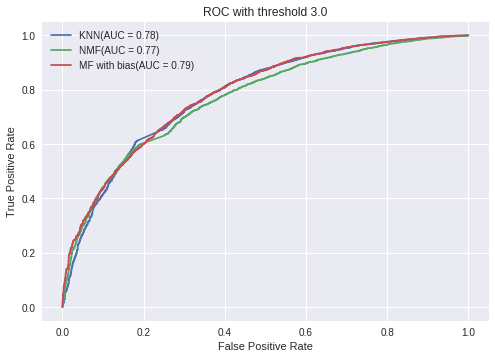

In [0]:
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
algos = [(KNNWithMeans(k=25, sim_options={'name':'pearson'}),'KNN'),(NMF(n_factors=20),'NMF'),(SVD(n_factors=26),'MF with bias')]
t=3
for algo,name in algos:
  trainset, testset = train_test_split(data_s, test_size=.1)
  algo.fit(trainset)
  predictions = algo.test(testset)
  y_true = []
  y_est = []
  for row in predictions:
    y_true.append(row.r_ui)
    y_est.append(row.est)
  
  #convert rating to binary scale
  binary_true=[]
  for i in range(len(y_true)):
    binary_true.append(1 if y_true[i] >= t else 0)  
    
  
  #plot roc curve
  fpr, tpr, threshold = roc_curve(binary_true, y_est)
  roc_auc = roc_auc_score(binary_true, y_est)
  plt.plot(fpr, tpr,label=name+'(AUC = %0.2f)' % roc_auc)
plt.title('ROC with threshold %0.1f' % t)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Ranking

### 1. Ranking predictions

### 2. Evaluating ranking using precision-recall curve

**Question 35: Precision and Recall are defined by the mathematical expres- sions given by equations 12 and 13 respectively. Please explain the meaning of precision and recall in your own words.**

In [0]:
from collections import defaultdict
def precision_recall_at_k(predictions, k, threshold=3):
    '''Return precision and recall at k metrics for each user.
    CODE ADAPTED from : https://surprise.readthedocs.io/en/stable/FAQ.html#how-to-compute-precision-k-and-recall-k'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

**Question 36: Plot average precision (Y-axis) against t (X-axis) for the rank- ing obtained using k-NN collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use the k found in question 11 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.**

In [0]:
kf = KFold(n_splits=10)
ks = np.arange(1,26)
knn_precisions = {}
knn_precisions_avg = []
knn_recalls = {}
knn_recalls_avg = []
for trainset, testset in kf.split(data_s):
  algo = KNNWithMeans(k=25, sim_options={'name':'pearson'})
  algo.fit(trainset)
  predictions = algo.test(testset)
  for k in ks:
    precisions, recalls = precision_recall_at_k(predictions, k=k)
    try:
      knn_precisions[k]
    except:
      knn_precisions[k] = []
      knn_recalls[k] = []
    knn_precisions[k].append(sum(prec for prec in precisions.values()) / len(precisions))
    knn_recalls[k].append(sum(rec for rec in recalls.values()) / len(recalls))
for k in ks:
  knn_precisions_avg.append(np.mean(knn_precisions[k]))
  knn_recalls_avg.append(np.mean(knn_recalls[k]))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


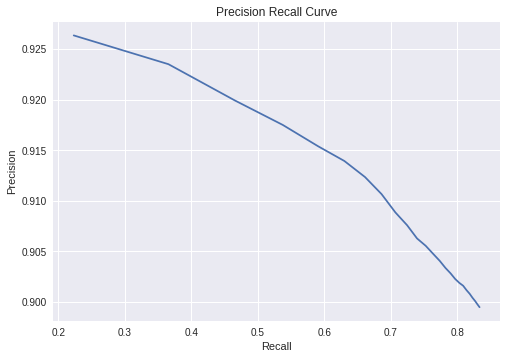

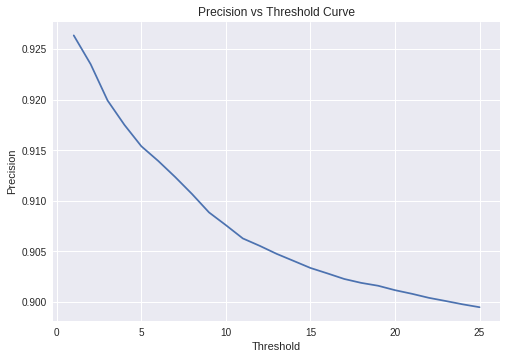

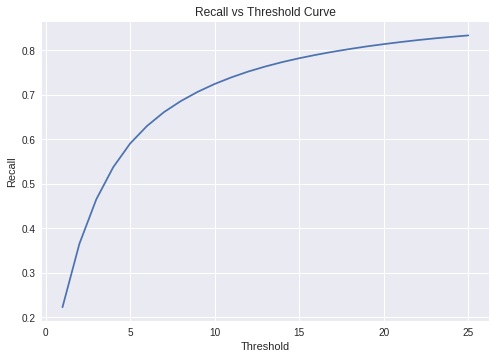

In [0]:
plt.plot(knn_recalls_avg,knn_precisions_avg)
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(ks,knn_precisions_avg)
plt.title('Precision vs Threshold Curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

plt.plot(ks,knn_recalls_avg)
plt.title('Recall vs Threshold Curve')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

**Question 37: Plot average precision (Y-axis) against t (X-axis) for the rank- ing obtained using NNMF-based collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use optimal number of latent factors found in question 18 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.**

In [0]:
kf = KFold(n_splits=10)
ks = np.arange(1,26)
nmf_precisions = {}
nmf_precisions_avg = []
nmf_recalls = {}
nmf_recalls_avg = []
for trainset, testset in kf.split(data_s):
  algo = NMF(n_factors=20)
  algo.fit(trainset)
  predictions = algo.test(testset)
  for k in ks:
    precisions, recalls = precision_recall_at_k(predictions, k=k)
    try:
      nmf_precisions[k]
    except:
      nmf_precisions[k] = []
      nmf_recalls[k] = []
    nmf_precisions[k].append(sum(prec for prec in precisions.values()) / len(precisions))
    nmf_recalls[k].append(sum(rec for rec in recalls.values()) / len(recalls))
for k in ks:
  nmf_precisions_avg.append(np.mean(nmf_precisions[k]))
  nmf_recalls_avg.append(np.mean(nmf_recalls[k]))

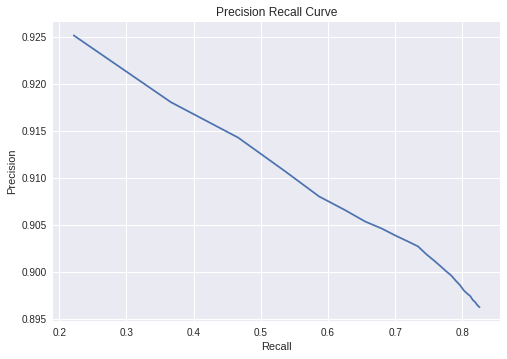

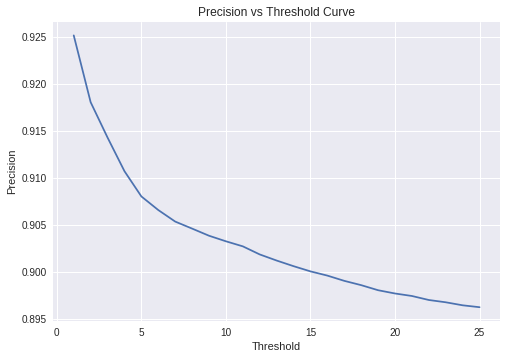

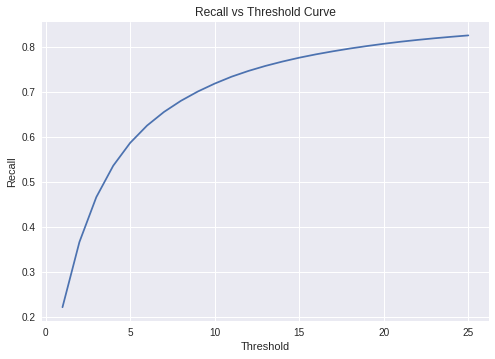

In [0]:
plt.plot(nmf_recalls_avg,nmf_precisions_avg)
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(ks,nmf_precisions_avg)
plt.title('Precision vs Threshold Curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

plt.plot(ks,nmf_recalls_avg)
plt.title('Recall vs Threshold Curve')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

**Question 38: Plot average precision (Y-axis) against t (X-axis) for the ranking obtained using MF with bias-based collaborative filter predictions. Also, plot the average recall (Y-axis) against t (X-axis) and average precision (Y-axis) against average recall (X-axis). Use optimal number of latent factors found in question 25 and sweep t from 1 to 25 in step sizes of 1. For each plot, briefly comment on the shape of the plot.**

In [0]:
kf = KFold(n_splits=10)
ks = np.arange(1,26)
mf_precisions = {}
mf_precisions_avg = []
mf_recalls = {}
mf_recalls_avg = []
for trainset, testset in kf.split(data_s):
  algo = SVD(n_factors=26)
  algo.fit(trainset)
  predictions = algo.test(testset)
  for k in ks:
    precisions, recalls = precision_recall_at_k(predictions, k=k)
    try:
      mf_precisions[k]
    except:
      mf_precisions[k] = []
      mf_recalls[k] = []
    mf_precisions[k].append(sum(prec for prec in precisions.values()) / len(precisions))
    mf_recalls[k].append(sum(rec for rec in recalls.values()) / len(recalls))
for k in ks:
  mf_precisions_avg.append(np.mean(mf_precisions[k]))
  mf_recalls_avg.append(np.mean(mf_recalls[k]))

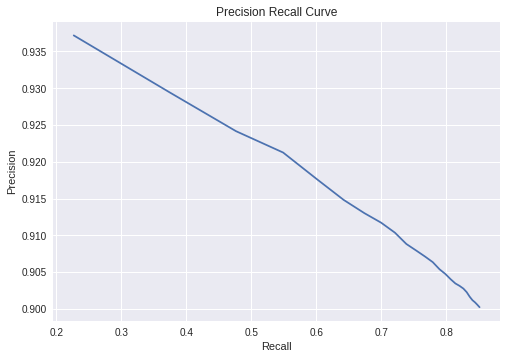

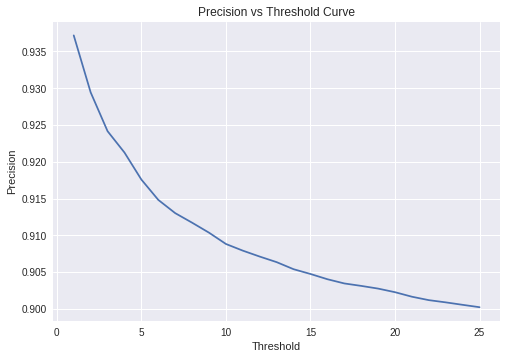

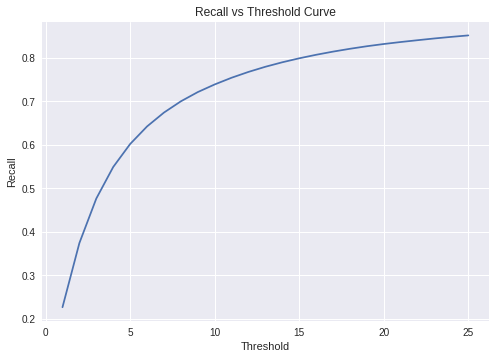

In [0]:
plt.plot(mf_recalls_avg,mf_precisions_avg)
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(ks,mf_precisions_avg)
plt.title('Precision vs Threshold Curve')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

plt.plot(ks,mf_recalls_avg)
plt.title('Recall vs Threshold Curve')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

**Question 39: Plot the precision-recall curve obtained in questions 36,37, and 38 in the same figure. Use this figure to compare the relevance of the recom- mendation list generated using k-NN, NNMF, and MF with bias predictions.**

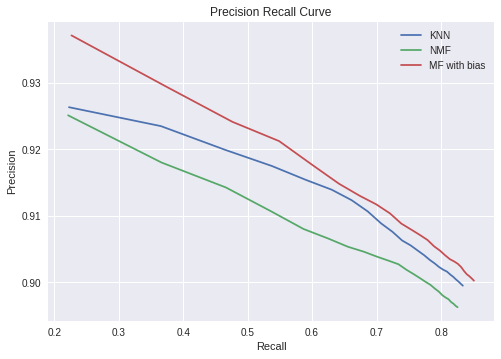

In [0]:
plt.plot(knn_recalls_avg,knn_precisions_avg,label='KNN')
plt.plot(nmf_recalls_avg,nmf_precisions_avg,label='NMF')
plt.plot(mf_recalls_avg,mf_precisions_avg,label='MF with bias')
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()